## Question 1

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 

### Part 4

In [4]:
def eigen_vals(t, U):
    # Create hamiltonian matrix
    H = np.matrix(
        [
            [0, 0, -t, -t],
            [0, 0, t, t],
            [-t, t, U, 0],
            [-t, +t, 0, U]
        ]
    )

    # Generate values and vectors
    H_values, H_vectors = np.linalg.eig(H)
    
    return H_values

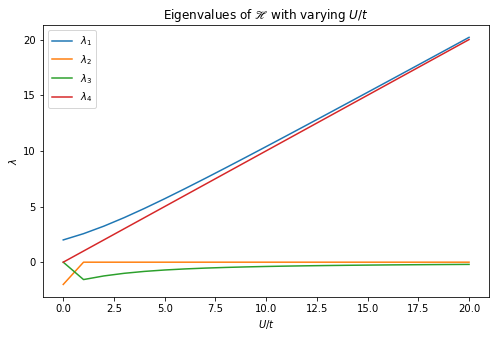

In [33]:
# Generate eigenvals for varying U/t and store them in an array
eigen_vals_array = []
spacing = 1
U_t_vals = np.arange(0, 20+spacing, spacing)

for val in np.arange(0, 20+spacing, spacing):
    eigen_vals_array.append(eigen_vals(1, val))

# Convert to numpy array to make manipulation easier
eigen_vals_array = np.array(eigen_vals_array)

fig = plt.figure(figsize=(8,5))

for index in range(0, 4):
    plt.plot(U_t_vals, eigen_vals_array[:, index], label=f'$\lambda_{index+1}$')
    
plt.title("Eigenvalues of $\mathscr{H}$ with varying $U/t$")
plt.xlabel("$U/t$")
plt.ylabel('$\lambda$')
plt.legend()